In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
kB = 1

## IsingSolver class definition:

In [9]:
class IsingSolver:
    '''a class to store data and methods for an Ising model implementation'''
    
    def __init__(self, grid_type='square', dim=100, pbcs=True, J=[1], Jrule='nn',h=0, starting_temp=1):
        '''initialises a solution to the Ising Model'''
        
        self.grid_type=grid_type
        self.dim=dim
        self.pbcs=pbcs
        self.J=J
        self.Jrule ='nn'
        self.h=h
        #introduce new h variable
        self.neighbours = []
        
                
        #create grid
        if self.grid_type == 'square':
            self.create_square_grid()
            
        
        #random initialisation of moments
        self.init_moments = np.random.choice([-1,1], self.X.shape )
        self.current_moments = np.copy(self.init_moments)    
        self.magnetisation =  self.current_moments.flatten().sum() 
        self.maglist = []
        self.maglist.append(self.magnetisation/ self.num_sites)
        
        self.energy_list = []
        self.current_energy = self.grid_energy(self.current_moments)
        self.energy_list.append(self.current_energy/ self.num_sites)
        self.temp = starting_temp
        
        if self.Jrule == 'nn':
            self.sums = np.array([-4, -2, 0, 2, 4, -3, -1, 1, 3])
            self.probs = np.exp(- 2 * (J[0]+self.h) *self.sums / (kB * self.temp) )
    #probability changes with the effect of h
        
    def grid_energy(self, moments):
        '''calculates the TOTAL energy for the full grid. Usually only done once, at the start...'''
        energy=0.0 +self.h #inital energy changed
        if self.Jrule == 'nn':
            for i, mom in enumerate(moments):
                for neighbour in self.neighbours[i]:
                    if neighbour > i:
                        energy += (-self.J[0]) * mom * moments[neighbour] 
            
        return energy

        
    def single_update(self):
        '''update by cycling through every moment in the lattice once.'''
        
        newE = self.current_energy
        if self.Jrule == 'nn':
            for i, mom in enumerate(self.current_moments):
                neighsum = np.sum(mom*self.current_moments[self.neighbours[i]])
                deltaE = -2 *self.J[0] * neighsum + 2*self.h*(np.sum(self.current_moments))
                #external field affects delta e
                deltaM = 0 
                
                if(deltaE <= 0):
                    newE += deltaE
                    self.current_moments[i] = - self.current_moments[i]
                    deltaM = 2*self.current_moments[i]  
                
                if(deltaE > 0):
                    prob = self.probs[np.where(self.sums == neighsum)]
                    if np.random.random() < prob :
                        newE += deltaE
                        self.current_moments[i] =  - self.current_moments[i]
                        deltaM = 2*self.current_moments[i] 
                
                self.magnetisation += deltaM
                    
        self.current_energy = newE
        self.energy_list.append(newE / self.num_sites)
        self.maglist.append(self.magnetisation/ self.num_sites)
        
        
    def run(self, num_its=100, h=0,temp=-1):
        '''Sweep through the lattice multiple times.
        Update the presaved probs array if a temperature is specified.'''
        if(h != 0):
            self.h = h
            if self.Jrule == 'nn':
                self.probs = np.exp(- 2 * (self.J[0]+self.h) *self.sums / (kB * self.temp) )
            #allows runs to iterate over h as well as temp
            
        if(temp != -1):
            self.temp=temp
            if self.Jrule == 'nn':
                self.probs = np.exp(- 2 * (self.J[0]+self.h)*self.sums/(kB * self.temp))
                
        for it in range(num_its):
             self.single_update()
            
        
    def grid_figure(self, moments, figsize=(8,8)):
        '''Create a figure to show a particular configuration'''
        fig, ax=plt.subplots(figsize=figsize)
        ax.set_aspect('equal')
        ax.scatter(self.X, self.Y, c=moments, marker='o', s=2000*(figsize[0]/self.dim)**2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(self.Y.min(), self.Y.max())
        ax.set_xlim(self.X.min(), self.X.max())
        return fig,ax
        
        
    def create_square_grid(self):
        '''Create a square grid of spins and the associated lists of neighbouring sites'''
        x, y = np.linspace(0, self.dim-1, self.dim), np.linspace(0, self.dim-1, self.dim)
        Y, X = np.meshgrid(y, x)
        self.X, self.Y = X.flatten(), Y.flatten()
        self.num_sites = self.dim * self.dim
        
        #list of neighbours for each site - different conditions with and without periodic boundaries
        for i, (x1, y1) in enumerate(zip(self.X, self.Y)):
       
            # if the lattice has periodic boundary conditions
            if self.pbcs == True:
                templist = [[ (x1-1) % self.dim , y1], [(x1+1)% self.dim , y1], [x1, (y1-1) % self.dim], [x1, (y1+1) % self.dim]]
                reallist = [int(a[0]*self.dim + a[1]) for a in templist ]
                self.neighbours.append(reallist)
                
            if self.pbcs == False:
                #if periodic boundary conditions are turned off
                templist = [[ (x1-1) , y1], [(x1+1) , y1], [x1, (y1-1) ], [x1, (y1+1) ]]
                tlist2=[]
                for element in templist:
                    if (element[0] >= 0) and (element[1] >= 0) and (element[0]< self.dim) and (element[1] < self.dim):
                        tlist2.append(element)
                reallist = [int(a[0]*self.dim + a[1]) for a in tlist2 ]
                self.neighbours.append(reallist)   
 

## Creating an instance of the solver:

Initial configuration:


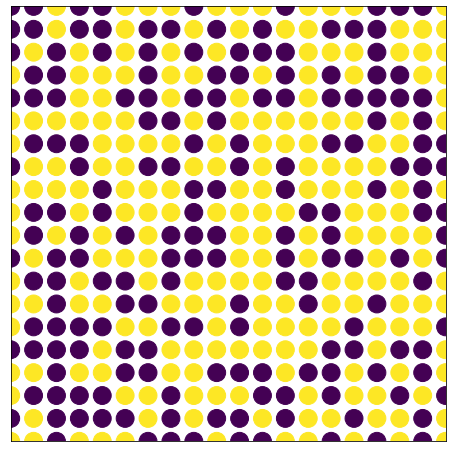

In [11]:

#create a solver, and plot the initial (random) state
solve = IsingSolver(J=[1], dim=20, pbcs=True,h=0, starting_temp=1)
print('Initial configuration:')
fig, ax = solve.grid_figure(solve.current_moments)
plt.show()

## Sweeping the lattice at a fixed temperature:

Final configuration:


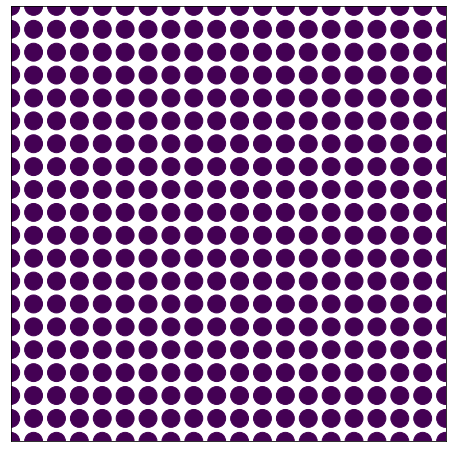

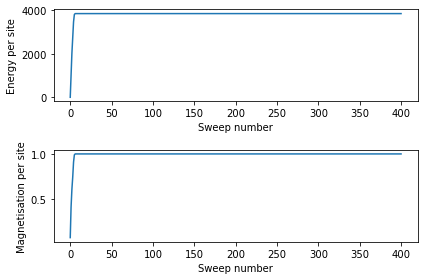

In [41]:
# run a certain number of sweeps at a certain temperature and plot the final state
#solve.run(num_its = 400,h=10, temp=5)
#print('Final configuration:')
#fig, ax = solve.grid_figure(solve.current_moments)
#plt.show()

# plot the evolution of energy and magnetisation per site
#figa, axa = plt.subplots(2)
#axa[0].plot(solve.energy_list)
#axa[0].set_xlabel('Sweep number')
#axa[0].set_ylabel('Energy per site')
#axa[1].plot(solve.maglist)
#axa[1].set_xlabel('Sweep number')
#axa[1].set_ylabel('Magnetisation per site')
#plt.tight_layout()
#plt.show()

## Looping over temperature and plotting thermodynamic variables

In [42]:
#templist = np.linspace(5.0, 1.0, 21)                # create a list of temperatures (decreasing order -- why?)

# lists to store average properties for each temperature
#avgmag = np.zeros_like(templist)
#aveng = np.zeros_like(templist)
#stdeng=np.zeros_like(templist)
#stdmag=np.zeros_like(templist)

# number of equilibriation and averaging sweeps for each temperature
#testruns, countruns = 200, 200

#for i, temp in enumerate(templist):
    #warm up and run
 #   solve.run(num_its = testruns + countruns, temp=temp)
  #  aveng[i] = np.mean(solve.energy_list[-countruns:])
   # avgmag[i] = np.mean((solve.maglist[-countruns:]))                 ## why the abs here?
   # stdeng[i] = np.std(solve.energy_list[-countruns:])
   # stdmag[i] = np.std(np.abs(solve.maglist[-countruns:]))

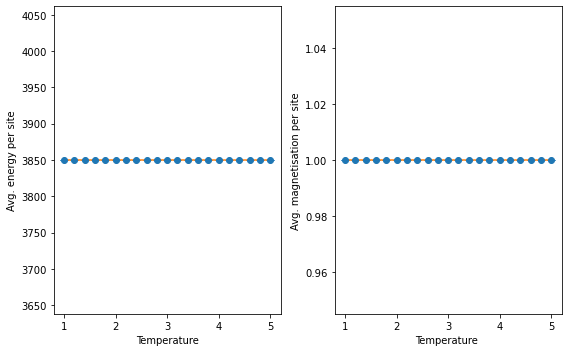

In [43]:
#fig3 = plt.figure(figsize=(8, 5))
#ax2 = fig3.add_subplot(121)
#ax2.errorbar(templist, aveng, yerr=stdeng, fmt='o', capsize=4)
#ax2.plot(templist, aveng, '-')
#ax2.set_xlabel('Temperature')
#ax2.set_ylabel('Avg. energy per site')


#ax3 = fig3.add_subplot(122)
#ax3.errorbar(templist, (avgmag), yerr=stdmag, fmt='o', capsize=4)
#ax3.plot(templist, (avgmag), '-')
#ax3.set_xlabel('Temperature ')
#ax3.set_ylabel('Avg. magnetisation per site')

#plt.tight_layout()

plt.show()

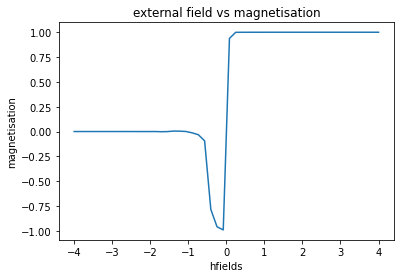

In [32]:

Hmax = 4
#define a maximum value of Hmax
Hfields = np.linspace(-Hmax,Hmax,50)
#linspace of Hfields 


avgmag = np.zeros_like(Hfields)
aveng = np.zeros_like(Hfields)
stdeng=np.zeros_like(Hfields)
stdmag=np.zeros_like(Hfields)
#empty spaces to fill up with relevant values from for loop
# number of equilibriation and averaging sweeps for each temperature
testruns, countruns = 0,100
#no of sweeps, is changed to 1 when initialising

for i, H in enumerate(Hfields):
    solve.run(num_its = testruns + countruns, h=H,temp=1.3)
   #
    #aveng[i] = np.mean(solve.energy_list[-countruns:])
    avgmag[i] = np.mean(solve.maglist[-countruns:])
    if  H==Hmax:   #(len(avgmag)%50==0):
        plt.figure(1)
        plt.plot(Hfields,avgmag)
 #loop the run command over various values of h and plot the average magnetism that results from each of these       
        
#uncomment these lines to obtain plots for varying temperatures
#for i, H in enumerate(Hfields):
 #   solve.run(num_its = testruns + countruns, h=H,temp=2.27)
   #
    #aveng[i] = np.mean(solve.energy_list[-countruns:])
  #  avgmag[i] = np.mean(solve.maglist[-countruns:])
   # if  H==Hmax:   #(len(avgmag)%50==0):
    #    plt.figure(2)
     #   plt.plot(Hfields,avgmag)
#for i, H in enumerate(Hfields):
 #   solve.run(num_its = testruns + countruns, h=H,temp=3)
   #
    #aveng[i] = np.mean(solve.energy_list[-countruns:])
  #  avgmag[i] = np.mean(solve.maglist[-countruns:])
   # if  H==Hmax:   #(len(avgmag)%50==0):
    #    plt.figure(3)
     #   plt.plot(Hfields,avgmag)

plt.xlabel('hfields')
plt.ylabel('magnetisation')
plt.title('external field vs magnetisation')
plt.show()
#labels plot and shows it below      


